# Looking for data on Age and Ethnicity

In [1]:
import sys
if "../../" not in sys.path:
    sys.path.append("../../")

In [281]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from importlib import reload
from tqdm import tqdm_notebook as tqdm
from sklearn import linear_model as lm
import seaborn as sns
from fuzzywuzzy import fuzz
import time

import pdaactconn as pc
from trialexplorer import AACTStudySet

import matplotlib.pyplot as plt
%matplotlib inline

params = {'xtick.labelsize':'x-large', 'ytick.labelsize':'x-large',
         'figure.figsize': (12,5), "axes.labelsize":'x-large'}
plt.rcParams.update(params)

In [3]:
# loading all interventional studies
conn = pc.AACTConnection(source=pc.AACTConnection.REMOTE)
ss = AACTStudySet.AACTStudySet(conn=conn, 
                               tqdm_handler=tqdm)
ss.add_constraint("study_type = 'Interventional'")
ss.load_studies()

278931 studies loaded!


In [4]:
# adding and loading dimensional data
ss.add_dimensions(['baseline_measurements',
                   'result_groups',
                   'eligibilities',
                   'outcomes',
                   'outcome_counts',
                   'outcome_measurements'])
ss.refresh_dim_data()

Successfuly added these 6 dimensions: ['baseline_measurements', 'result_groups', 'eligibilities', 'outcomes', 'outcome_counts', 'outcome_measurements']
Failed to add these 0 dimensions: []


Syncing the temp table temp_cur_studies in 558 chunks x 500 records each

Creating index on the temp table
 - Loading dimension baseline_measurements
 -- Loading raw data
 -- Sorting index
 - Loading dimension result_groups
 -- Loading raw data
 -- Sorting index
 - Loading dimension eligibilities
 -- Loading raw data
 -- Sorting index
 - Loading dimension outcomes
 -- Loading raw data
 -- Sorting index
 - Loading dimension outcome_counts
 -- Loading raw data
 -- Sorting index
 - Loading dimension outcome_measurements
 -- Loading raw data
 -- Sorting index


In [5]:
# setting all the dimensional data to variables
bm = ss.dimensions['baseline_measurements'].data
rg = ss.dimensions['result_groups'].data
el = ss.dimensions['eligibilities'].data
out = ss.dimensions['outcomes'].data
oc = ss.dimensions['outcome_counts'].data
om = ss.dimensions['outcome_measurements'].data

In [6]:
# total number of studies
num_all = ss.studies.shape[0]
num_all

278931

In [8]:
# baseline measurement studies
bm_all = bm.index.get_level_values(0).unique().shape[0]
bm_all, bm_all / num_all

(42773, 0.1533461680487289)

### About 15% of the studies report Baseline Measurements

In [9]:
bm.columns

Index(['id', 'ctgov_group_code', 'classification', 'category', 'title',
       'description', 'units', 'param_type', 'param_value', 'param_value_num',
       'dispersion_type', 'dispersion_value', 'dispersion_value_num',
       'dispersion_lower_limit', 'dispersion_upper_limit',
       'explanation_of_na'],
      dtype='object')

# Steps 1-3 are investigative, step 4 starts implementation

# 1. Category column in BM

investingating the category column in the baseline measurements table

In [109]:
bmr = bm.reset_index()

In [110]:
all_cats = bmr.groupby('category')['nct_id'].count().sort_values(ascending=False)
all_cats

category
                           548040
Male                       121470
Female                     121470
Unknown or Not Reported     54358
>=65 years                  39389
                            ...  
Number of sound teeth           1
Number of unsound teeth         1
Almost never                    1
Almost clear (1)                1
sGC stimulator                  1
Name: nct_id, Length: 9904, dtype: int64

In [111]:
# seaching for specific keywords that indicate race
# this list was determined by looking at the top categories by count
possible_keywords = ['white', 'asian', 'african', 'indian', 
                     'native', 'islander', 'latino', 'hispanic']


# finding all category labels such that it matches above keywords
used_cats = []
for cur_cat in all_cats.index:
    for kw in possible_keywords:
        if kw in cur_cat.lower():
            if cur_cat not in used_cats:
                used_cats.append(cur_cat)
            next

In [112]:
# found this many categories that match race with atleast 1000 studies:
matched_cat_counts = all_cats.loc[used_cats]
used_cat_counts = matched_cat_counts[matched_cat_counts >= 1000]
len(used_cat_counts)

7

In [16]:
# let's eye ball through the list
used_cat_counts

category
White                                        33931
Asian                                        33328
Black or African American                    32616
American Indian or Alaska Native             31764
Native Hawaiian or Other Pacific Islander    31424
Hispanic or Latino                           24278
Not Hispanic or Latino                       24115
Name: nct_id, dtype: int64

In [17]:
used_cats = list(used_cat_counts.index)
used_cats

['White',
 'Asian',
 'Black or African American',
 'American Indian or Alaska Native',
 'Native Hawaiian or Other Pacific Islander',
 'Hispanic or Latino',
 'Not Hispanic or Latino']

### What are the characteristics of the studies that have these used categories?

In [18]:
df_cat = bm[bm['category'].isin(used_cats)]

In [113]:
# what are the titles of studies with the short-listed categories
s_cat_by_count = df_cat.groupby('title')['id'].count().sort_values(ascending=False)
s_cat_by_count

title
Race (NIH/OMB)                                      153610
Ethnicity (NIH/OMB)                                  46850
Race/Ethnicity, Customized                           10600
Race                                                   206
Ethnicity                                              103
Race (NIH/OMB) (Influenza Season 2016-2017)             15
Race (NIH/OMB) (Influenza Season 2015-2016)             15
Race, Customized                                        14
Race/Ethnicity                                           9
Primary Race                                             9
Ethnicty                                                 6
Ethnicity (NIH/OMB) (Influenza Season 2016-2017)         6
Ethnicity (NIH/OMB) (Influenza Season 2015-2016)         6
Race (Asian vs Non-Asian) at Randomization               3
Maternal Race                                            3
Donor Race/Ethnicity                                     1
Name: id, dtype: int64

In [114]:
# can just use the top few to capture most of the data
used_cat_titles = s_cat_by_count.index[:4]
used_cat_titles


Index(['Race (NIH/OMB)', 'Ethnicity (NIH/OMB)', 'Race/Ethnicity, Customized',
       'Race'],
      dtype='object', name='title')

### if we filter the original data by these titles, do we get back the original categories?

In [115]:
df_by_titles = bm[bm['title'].isin(used_cat_titles)]
df_by_titles.head()

id ctgov_group_code    classification  \
nct_id      result_group_id                                                
NCT00000125 17107296         19452826               B3             Other   
            17107296         19452829               B3             White   
            17107296         19452832               B3          Hispanic   
            17107296         19452835               B3  African American   
            17107296         19452838               B3             Asian   

                            category                       title description  \
nct_id      result_group_id                                                    
NCT00000125 17107296                  Race/Ethnicity, Customized               
            17107296                  Race/Ethnicity, Customized               
            17107296                  Race/Ethnicity, Customized               
            17107296                  Race/Ethnicity, Customized               
            17107296                  Race/Ethnicity, Customized               

                                    units param_type param_value  \
nct_id      result_group_id                                        
NCT00000125 17107296         participants     Number          14   
            17107296         participants     Number        1137   
            17107296         participants     Number          59   
            17107296         participants     Number         408   
            17107296         participants     Number          14   

                             param_value_num dispersion_type dispersion_value  \
nct_id      result_group_id                                                     
NCT00000125 17107296                    14.0                             None   
            17107296                  1137.0                             None   
            17107296                    59.0                             None   
            17107296                   408.0                             None   
            17107296                    14.0                             None   

                             dispersion_value_num  dispersion_lower_limit  \
nct_id      result_group_id                                                 
NCT00000125 17107296                          NaN                     NaN   
            17107296                          NaN                     NaN   
            17107296                          NaN                     NaN   
            17107296                          NaN                     NaN   
            17107296                          NaN                     NaN   

                             dispersion_upper_limit explanation_of_na  
nct_id      result_group_id                                            
NCT00000125 17107296                            NaN                    
            17107296                            NaN                    
            17107296                            NaN                    
            17107296                            NaN                    
            17107296                            NaN

In [116]:
counts_by_title_cats = df_by_titles.groupby('category')['id'].count().sort_values(ascending=False)
counts_by_title_cats[counts_by_title_cats > 1000]

category
                                             79588
Unknown or Not Reported                      54240
White                                        33912
Asian                                        33310
Black or African American                    32599
American Indian or Alaska Native             31755
Native Hawaiian or Other Pacific Islander    31418
More than one race                           30802
Hispanic or Latino                           24213
Not Hispanic or Latino                       24059
Other                                         2454
Black                                         1016
Name: id, dtype: int64

### Looks like we do, except for a bunch of blank categories

### Q: Are the blanks for totals?

In [118]:
df_blank_cat = df_by_titles[df_by_titles['category'] == '']
df_blank_cat.groupby('classification')['id'].count().sort_values(ascending=False)[:10]

classification
White                                        9162
Asian                                        8645
Other                                        6563
Black or African American                    4734
Black                                        3643
Caucasian                                    2862
American Indian or Alaska Native             2807
Hispanic                                     2740
Hispanic or Latino                           2242
Native Hawaiian or Other Pacific Islander    1883
Name: id, dtype: int64

### A: Looks like those with blank category will have a classification reported with the ethnicity

so either the race is reported in the "category" field or the "classification" field

### "Category" Summary:
- scanning the category column for matched string ethnicities, we found a short list of titles that narrow down these ethnicities. 
    -- This is stored in the variable: used_cat_titles
- Filtering by these titles, we see that there is still many rows with blank categorys
- Found that these rows have the ethnicity tagged in the "classification" column

# 2. Classification column in BM

In [120]:
all_classes = bmr.groupby('classification')['nct_id'].count().sort_values(ascending=False)
all_classes

classification
                                        903141
United States                            48246
White                                     9313
Asian                                     8824
Other                                     7914
                                         ...  
Participants pretreated with opioids         1
High school degree                           1
T2N2                                         1
T2N1                                         1
History of previous loss                     1
Name: nct_id, Length: 26568, dtype: int64

In [121]:
possible_keywords = ['white', 'asian', 'african', 'indian', 
                     'native', 'islander', 'latino', 'hispanic']


# finding all category labels such that it matches above keywords
used_classes = []
for cur_class in all_classes.index:
    for kw in possible_keywords:
        if kw in cur_class.lower():
            if cur_class not in used_classes:
                used_classes.append(cur_class)
            next

In [122]:
# found this many categories that match race with atleast 100 studies:
matched_class_counts = all_classes.loc[used_classes]
used_class_counts = matched_class_counts[matched_class_counts >= 100]
len(used_class_counts)

44

In [123]:
used_classes = list(used_class_counts.index)
used_classes

['White',
 'Asian',
 'Black or African American',
 'Caucasian',
 'Hispanic',
 'American Indian or Alaska Native',
 'Hispanic or Latino',
 'Native Hawaiian or Other Pacific Islander',
 'Not Hispanic or Latino',
 'African American',
 'African American/African Heritage',
 'Black/African American',
 'Native American',
 'Native Hawaiian or other Pacific Islander',
 'American Indian or Alaskan Native',
 'White - White/Caucasian/European Heritage',
 'Asian - East Asian Heritage',
 'Asian - South East Asian Heritage',
 'Hispanic/Latino',
 'White or Caucasian',
 'Asian - Japanese Heritage',
 'Asian - Central/South Asian Heritage',
 'African',
 'White - Arabic/North African Heritage',
 'White/Caucasian',
 'African-American',
 'East Asian',
 'Native Hawaiian or Pacific Islander',
 'Pacific Islander',
 'American Indian',
 'White Non-Hispanic',
 'American Indian/Alaska Native',
 'Asian/Pacific Islander',
 'American Indian/Alaskan Native',
 'Non-Hispanic White',
 'Indian',
 'Caucasian/White',
 'Non-

### What are the characteristics of the studies that have these used classifications?

In [124]:
df_class = bm[bm['classification'].isin(used_classes)]

In [125]:
s_class_by_count = df_class.groupby('title')['id'].count().sort_values(ascending=False)
s_class_by_count[:10]

title
Race/Ethnicity, Customized    45553
Race/Ethnicity                  800
Race (NIH/OMB)                  696
Race                            674
Ethnicity                       337
Ethnicity (NIH/OMB)             116
Predominant Race                 40
Race/Ethnicity, customized       40
Racial Group                     30
Race - U.S.A.                    21
Name: id, dtype: int64

### can just go with those with > 100 rows

In [126]:
# can just use the top few:
used_class_titles = s_class_by_count[s_class_by_count > 100].index
sorted(used_class_titles)

['Ethnicity',
 'Ethnicity (NIH/OMB)',
 'Race',
 'Race (NIH/OMB)',
 'Race/Ethnicity',
 'Race/Ethnicity, Customized']

In [127]:
sorted(used_cat_titles)

['Ethnicity (NIH/OMB)', 'Race', 'Race (NIH/OMB)', 'Race/Ethnicity, Customized']

### Looks like the class titles have extra vs cat titles:
- Ethnicity
- Race/Ethnicity

But is otherwise a superset

### if we filter by these titles, do we get back the original classifications?

In [128]:
df_by_titles = bm[bm['title'].isin(used_class_titles)]
df_by_titles.head()

id ctgov_group_code    classification  \
nct_id      result_group_id                                                
NCT00000125 17107296         19452826               B3             Other   
            17107296         19452829               B3             White   
            17107296         19452832               B3          Hispanic   
            17107296         19452835               B3  African American   
            17107296         19452838               B3             Asian   

                            category                       title description  \
nct_id      result_group_id                                                    
NCT00000125 17107296                  Race/Ethnicity, Customized               
            17107296                  Race/Ethnicity, Customized               
            17107296                  Race/Ethnicity, Customized               
            17107296                  Race/Ethnicity, Customized               
            17107296                  Race/Ethnicity, Customized               

                                    units param_type param_value  \
nct_id      result_group_id                                        
NCT00000125 17107296         participants     Number          14   
            17107296         participants     Number        1137   
            17107296         participants     Number          59   
            17107296         participants     Number         408   
            17107296         participants     Number          14   

                             param_value_num dispersion_type dispersion_value  \
nct_id      result_group_id                                                     
NCT00000125 17107296                    14.0                             None   
            17107296                  1137.0                             None   
            17107296                    59.0                             None   
            17107296                   408.0                             None   
            17107296                    14.0                             None   

                             dispersion_value_num  dispersion_lower_limit  \
nct_id      result_group_id                                                 
NCT00000125 17107296                          NaN                     NaN   
            17107296                          NaN                     NaN   
            17107296                          NaN                     NaN   
            17107296                          NaN                     NaN   
            17107296                          NaN                     NaN   

                             dispersion_upper_limit explanation_of_na  
nct_id      result_group_id                                            
NCT00000125 17107296                            NaN                    
            17107296                            NaN                    
            17107296                            NaN                    
            17107296                            NaN                    
            17107296                            NaN

In [129]:
counts_by_title_cats = df_by_titles.groupby('classification')['id'].count().sort_values(ascending=False)
counts_by_title_cats[counts_by_title_cats > 1000]

classification
                                             297572
White                                          9228
Asian                                          8746
Other                                          6670
Black or African American                      4783
Race                                           4584
Black                                          3708
Caucasian                                      3037
Hispanic                                       2955
American Indian or Alaska Native               2821
Hispanic or Latino                             2364
Native Hawaiian or Other Pacific Islander      1904
Not Hispanic or Latino                         1450
Race/Ethnicity                                 1396
Ethnicity                                      1200
Unknown                                        1055
African American                               1036
Name: id, dtype: int64

### Q: What are the blanks for?

In [130]:
df_blank_cat = df_by_titles[df_by_titles['classification'] == '']
df_blank_cat.groupby('category')['id'].count().sort_values(ascending=False)[:10]

category
Unknown or Not Reported                      53687
White                                        32545
Asian                                        32213
Black or African American                    31798
American Indian or Alaska Native             31216
Native Hawaiian or Other Pacific Islander    30953
More than one race                           30480
Hispanic or Latino                           23729
Not Hispanic or Latino                       23658
Other                                         1406
Name: id, dtype: int64

### A: We have cross coverage between classification and category for the same race/ethn titles

# 3. Narrowing the studies by Title, Classification and Category

In [132]:
# combining the valid titles from both category and classification
all_used_titles = []
for cur_title in used_class_titles:
    if cur_title not in all_used_titles:
        all_used_titles.append(cur_title)
        
for cur_title in used_cat_titles:
    if cur_title not in all_used_titles:
        all_used_titles.append(cur_title)       

all_used_titles        

['Race/Ethnicity, Customized',
 'Race/Ethnicity',
 'Race (NIH/OMB)',
 'Race',
 'Ethnicity',
 'Ethnicity (NIH/OMB)']

### Let's Eyeball through some examples by title

In [133]:
for cur_title in all_used_titles:
    print("BM Title: %s" % cur_title)
    sub_df = bm[bm['title'] == cur_title]
    all_nct_id = sub_df.index.get_level_values(0).unique()
    print(np.random.choice(all_nct_id, 5))
    print("\n")

BM Title: Race/Ethnicity, Customized
['NCT00699153' 'NCT00348348' 'NCT02764190' 'NCT02883452' 'NCT03208088']


BM Title: Race/Ethnicity
['NCT00191854' 'NCT00401973' 'NCT00350779' 'NCT00063570' 'NCT00192075']


BM Title: Race (NIH/OMB)
['NCT02671266' 'NCT00390455' 'NCT00989963' 'NCT02929667' 'NCT01458392']


BM Title: Race
['NCT01297465' 'NCT01324947' 'NCT00549302' 'NCT00373529' 'NCT01476475']


BM Title: Ethnicity
['NCT00298363' 'NCT01414114' 'NCT01896232' 'NCT03092726' 'NCT01288911']


BM Title: Ethnicity (NIH/OMB)
['NCT00754845' 'NCT03109184' 'NCT03480152' 'NCT02107599' 'NCT02338973']




### Notes:
- Some studies report both race and ethnicity as different metrics: NCT01611194
- looks like "Race (NIH/OMB) is the one that we want if both Ethnicity (NIH/OMB) and that are reported
- also drop the 2 ethnicity titles

In [134]:
# this determines the set of data used for the final race data set
final_used_titles = [x for x in all_used_titles if 'race' in x.lower()]
final_used_titles

['Race/Ethnicity, Customized', 'Race/Ethnicity', 'Race (NIH/OMB)', 'Race']

In [135]:
bm_used = bm[bm['title'].isin(final_used_titles)]

In [136]:
num_used = len(bm_used.index.get_level_values(0).unique())
num_used

17771

In [137]:
# this % of studies is covered by the current set
num_used / bm_all

0.41547237743436277

#### turns out to be 41% of those that report baseline measurements

# 4. Merging the category and classification into 1 used study set

In [138]:
double_counts = bm_used.groupby(['classification', 'category'])['id'].count().sort_values(ascending=False)
double_counts[double_counts > 500]

classification                             category                                 
                                           White                                        32545
                                           Asian                                        32213
                                           Black or African American                    31798
                                           American Indian or Alaska Native             31216
                                           Native Hawaiian or Other Pacific Islander    30953
                                           Unknown or Not Reported                      30515
                                           More than one race                           30480
White                                                                                    9223
Asian                                                                                    8725
Other                                                                

### Plan: We look at category first, then in the remaining where category is blank, look at the classification

In [139]:
cat_counts = bm_used.groupby('category')['id'].count().sort_values(ascending=False)
cat_counts[cat_counts > 100]

category
                                             80553
White                                        33915
Asian                                        33313
Black or African American                    32602
American Indian or Alaska Native             31755
Native Hawaiian or Other Pacific Islander    31418
Unknown or Not Reported                      30832
More than one race                           30802
Other                                         2457
Black                                         1016
Hispanic or Latino                             797
Not Hispanic or Latino                         625
Hispanic                                       596
Caucasian                                      502
Unknown                                        429
Not Permitted                                  334
Missing                                        242
Multiple                                       234
African American                               232
American Indian or Ala

In [140]:
# eyeballing which ones are the N/A categories
cat_unknowns = ['Unknown or Not Reported', 
                'More than one race', 
                'Unknown', 
                'Not Permitted', 
                'Missing', 
                'Multiple', 
                'Not Reported']

In [141]:
# why do we get the "ethnicity" labels still? (ex: Hispanic or Latino)
eth_cats = ['Hispanic or Latino', 'Not Hispanic or Latino']

## 4 a) Case 1: Category is non-blank

In [142]:
bm_used_case1 = bm_used[bm_used['category'] != '']

# already checked that the "Count of Participants" is the dominate param type
bm_used_case1 = bm_used_case1[bm_used_case1['param_type'] == 'Count of Participants']

# % of the data ..
print("Pct of bm rows: %.1f%%" % (bm_used_case1.shape[0] / bm_used.shape[0] * 100))

# unique ids for this case
case1_nct_ids = bm_used_case1.index.get_level_values(0).unique()

Pct of bm rows: 74.9%


In [143]:
bm_full_case1 = bm_used.loc[case1_nct_ids]
bm_full_case1 = bm_full_case1[bm_full_case1['param_type'] == 'Count of Participants']
print("Pct of bm rows: %.1f%%" % (bm_full_case1.shape[0] / bm_used.shape[0] * 100))

Pct of bm rows: 75.1%


In [144]:
bm_full_case1.groupby('param_type')['id'].count()

param_type
Count of Participants    241302
Name: id, dtype: int64

## Joining to result groups to get the group labels:

In [145]:
dfm_case1 = bm_full_case1.reset_index().merge(rg.reset_index()[['nct_id', 'ctgov_group_code', 'title']], 
                                              on=['nct_id', 'ctgov_group_code'], 
                                              how='inner', 
                                              suffixes=('', '_rg'))

In [146]:
dfm_case1.groupby('title_rg').size().sort_values(ascending=False)[:50].index

Index(['Total', 'Placebo', 'Control', 'Usual Care', 'All Participants',
       'All Study Participants', 'Control Group', 'Intervention',
       'Standard of Care', 'Overall Study', 'Treatment', 'Cohort 1',
       'Cohort 2', 'Sugar Pill', 'Arm 1', 'Vehicle', 'Overall',
       'Treatment Arm', 'Arm 2', 'Placebo Group', 'Cohort 3', 'Control Arm',
       'Arm A', 'Arm B', 'Arm I', 'Group 1', 'Group A', 'Group B', 'Group 2',
       'Single Arm', 'Arm II (Placebo)', 'All Patients', 'Normal Saline',
       'Entire Study Population', 'Standard Care', 'Treatment as Usual',
       'Intervention Group', 'Duloxetine', 'Saline', 'Varenicline', 'Active',
       'Cohort A', 'Pembrolizumab', 'Ketamine', 'Total Title', 'All Subjects',
       'Metformin', 'Placebo Arm', 'Cohort B', 'Dose Level 1'],
      dtype='object', name='title_rg')

### Need to get rid of the total rows

In [147]:
total_strings = ['Total', 
                 'All Participants', 
                 'All Study Participants', 
                 'Entire Study Population',
                 'Overall Study',
                 'Overall', 
                 'Total Title']

In [148]:
dfm_case1_nontot = dfm_case1[~dfm_case1['title_rg'].isin(total_strings)].copy()
len(dfm_case1_nontot['nct_id'].unique())

11877

In [149]:
df_case1_totcounts = dfm_case1_nontot.groupby('nct_id')[['param_value_num']].sum()
df_c1j = df_case1_totcounts.join(ss.studies[['enrollment']])
df_c1j['tot_per_enroll'] = df_c1j['param_value_num'] / df_c1j['enrollment']
df_c1j.head()

,param_value_num,enrollment,tot_per_enroll
nct_id,,,
NCT00001262,60.0,60.0,1.0
NCT00001304,27.0,27.0,1.0
NCT00001305,42.0,42.0,1.0
NCT00001575,87.0,87.0,1.0
NCT00001586,105.0,105.0,1.0


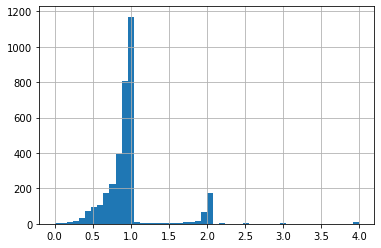

In [150]:
df_c1j[df_c1j['tot_per_enroll'] != 1.0]['tot_per_enroll'].clip(0, 4).hist(bins=50)

### Some studies report multiple times for ethnicity - should not be double counted

### Idea: let's just keep those studies with totals that sum up to smaller or equal to total enrollment

In [151]:
non_double_counted = df_c1j[df_c1j['param_value_num'] <= df_c1j['enrollment']]
non_double_counted.shape[0] / df_c1j.shape[0]

0.9692683337543151

In [152]:
df_final_case1 = dfm_case1_nontot[dfm_case1_nontot['nct_id'].isin(non_double_counted.index)].copy()

In [153]:
# % of rows in bm_used
df_final_case1.shape[0] / bm_used.shape[0]

0.5399311713931881

In [154]:
# % of nct_ids in bm_used
len(df_final_case1['nct_id'].unique()) / len(bm_used.index.get_level_values(0).unique())

0.6477969725958022

## 4 b) Case 2: Category is blank (look in the classification field)

In [155]:
bm_used_case2 = bm_used[bm_used['category'] == '']

# checked that these 2 are the dominate characterstics
bm_used_case2 = bm_used_case2[bm_used_case2['param_type'].isin(['Count of Participants', 'Number'])]


# % of the data ..
print("Pct of bm rows: %.1f%%" % (bm_used_case2.shape[0] / bm_used.shape[0] * 100))

# unique ids for this case
case2_nct_ids = bm_used_case2.index.get_level_values(0).unique()

Pct of bm rows: 25.0%


In [156]:
bm_full_case2 = bm_used.loc[case2_nct_ids]
bm_full_case2 = bm_full_case2[bm_full_case2['param_type'].isin(['Count of Participants', 'Number'])]
print("Pct of bm rows: %.1f%%" % (bm_full_case2.shape[0] / bm_used.shape[0] * 100))

Pct of bm rows: 25.6%


## Joining to result groups to get the group labels:

In [157]:
dfm_case2 = bm_full_case2.reset_index().merge(rg.reset_index()[['nct_id', 'ctgov_group_code', 'title']], 
                                              on=['nct_id', 'ctgov_group_code'], 
                                              how='inner', 
                                              suffixes=('', '_rg'))

In [158]:
dfm_case2.groupby('title_rg').size().sort_values(ascending=False)[:50].index

Index(['Total', 'Placebo', 'Control', 'Usual Care', 'Control Group',
       'All Participants', 'All Study Participants', 'Standard of Care',
       'Sitagliptin 100 mg', 'Duloxetine', 'Overall Study', 'Cinacalcet',
       'Treatment', 'Cohort 1', 'Cohort 2', 'Overall', 'Lixisenatide',
       'Intervention', 'Dispensed Subjects', 'Denosumab',
       'Denosumab 60 mg Q6M', 'Lapatinib', 'Placebo MDPI', 'Vehicle Foam',
       'Placebo Group', 'Vehicle', 'Iron Isomaltoside/Ferric Derisomaltose',
       'Sitagliptin', 'FF 100 µg OD', 'Fp MDPI 100 mcg', 'Standard Care',
       'Entire Study Population', 'Arm 1', 'SOF/VEL 12 Weeks', 'Placebo Q2W',
       'FF/VI 100/25 µg QD', 'Fasiglifam 50 mg', 'Metformin',
       'Vortioxetine 10 mg', 'Escitalopram', 'Placebo QD', 'Trastuzumab',
       'Etanercept', 'Insulin Glargine', 'VI 25 µg QD', 'FF/VI 100/25 µg OD',
       'Stribild', 'Cohort 3', 'Nimenrix Group', 'Atomoxetine'],
      dtype='object', name='title_rg')

In [159]:
# still the same total strings:
total_strings = ['Total', 
                 'All Participants', 
                 'All Study Participants', 
                 'Entire Study Population',
                 'Overall Study',
                 'Overall', 
                 'Total Title']

In [160]:
dfm_case2_nontot = dfm_case2[~dfm_case2['title_rg'].isin(total_strings)].copy()
len(dfm_case2_nontot['nct_id'].unique())

5501

In [161]:
df_case2_totcounts = dfm_case2_nontot.groupby('nct_id')[['param_value_num']].sum()
df_c2j = df_case2_totcounts.join(ss.studies[['enrollment']])
df_c2j['tot_per_enroll'] = df_c2j['param_value_num'] / df_c2j['enrollment']
df_c2j.head()

,param_value_num,enrollment,tot_per_enroll
nct_id,,,
NCT00000125,1636.0,1636.0,1.000000
NCT00000392,212.0,215.0,0.986047
NCT00000620,10251.0,10251.0,1.000000
NCT00001941,34.0,34.0,1.000000
NCT00002850,212.0,212.0,1.000000


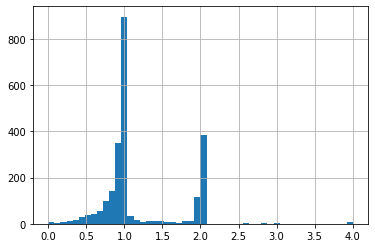

In [162]:
df_c2j[df_c2j['tot_per_enroll'] != 1.0]['tot_per_enroll'].clip(0, 4).hist(bins=50)

In [163]:
non_double_counted_case2 = df_c2j[df_c2j['param_value_num'] <= df_c2j['enrollment']]
non_double_counted_case2.shape[0] / df_c2j.shape[0]

0.8658425740774405

In [164]:
df_final_case2 = dfm_case2_nontot[dfm_case2_nontot['nct_id'].isin(non_double_counted_case2.index)].copy()

In [165]:
# % of rows in bm_used
df_final_case2.shape[0] / bm_used.shape[0]

0.14844824474606227

In [166]:
# % of nct_ids in bm_used
len(df_final_case2['nct_id'].unique()) / len(bm_used.index.get_level_values(0).unique())

0.2680209329806989

### Do we have any nct_ids in both cases?

In [167]:
c1_nct = df_final_case1['nct_id'].unique()
c2_nct = df_final_case2['nct_id'].unique()

In [168]:
[x for x in c1_nct if x in c2_nct]

['NCT01960075', 'NCT03237065']

only 2 cases, let's just take their case 1 datapoints

In [169]:
df_final_case1['used_race'] = df_final_case1['category']
df_final_case2['used_race'] = df_final_case2['classification']

df_final_case2_not_case1 = df_final_case2[~df_final_case2['nct_id'].isin(df_final_case1['nct_id'].unique())]

In [170]:
req_columns = [
    'nct_id', 
    'result_group_id',
    'title',
    'ctgov_group_code',
    'used_race',
    'param_value_num'
]

## 4 c) Joining together the cases

In [171]:
df_final_all = pd.concat([df_final_case1[req_columns], df_final_case2_not_case1[req_columns]])

In [172]:
df_final_all.shape[0] / bm_used.shape[0]

0.6882798449178227

In [173]:
# % of all nctids that report baseline measures
num_studies_report_race = len(df_final_all['nct_id'].unique())
num_studies_report_race / len(bm.index.get_level_values(0).unique()), num_studies_report_race

(0.38045028405769993, 16273)

In [174]:
dftotals = df_final_all.groupby('nct_id')[['param_value_num']].sum()

In [175]:
df_percentile_totals = dftotals.describe(np.arange(0,1,0.01))
df_percentile_totals.index.name='percentile'
df_percentile_totals.reset_index(inplace=True)
df_percentile_totals = df_percentile_totals[df_percentile_totals['percentile'].apply(lambda x: 
                                                                                     True if '%' in x 
                                                                                     else False)]
df_percentile_totals[15:25]

,percentile,param_value_num
19,15%,16.0
20,16%,18.0
21,17%,19.0
22,18%,20.0
23,19%,20.0
24,20%,21.0
25,21%,23.0
26,22%,24.0
27,23%,24.0
28,24%,25.0


### We picked to keep 80% of the data and exclude any studies such the total <= 20

In [176]:
df_totals_used = dftotals[dftotals['param_value_num'] > 20]
df_totals_used.shape

(13135, 1)

In [177]:
df_final_g20 = df_final_all[df_final_all['nct_id'].isin(df_totals_used.index.unique())]
df_final_g20.head()

,nct_id,result_group_id,title,ctgov_group_code,used_race,param_value_num
7,NCT00001262,17107073,Race (NIH/OMB),B3,Unknown or Not Reported,0.0
8,NCT00001262,17107073,Race (NIH/OMB),B3,More than one race,0.0
9,NCT00001262,17107073,Race (NIH/OMB),B3,White,3.0
10,NCT00001262,17107073,Race (NIH/OMB),B3,Black or African American,0.0
11,NCT00001262,17107073,Race (NIH/OMB),B3,Native Hawaiian or Other Pacific Islander,0.0


### Only keep those with 2 Arms

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8051173518>]],
      dtype=object)

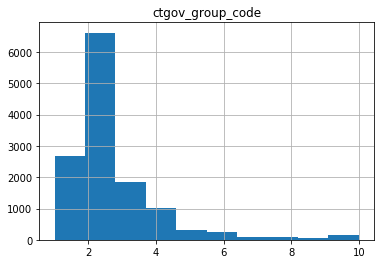

In [178]:
df_final_g20.groupby('nct_id')[['ctgov_group_code']].nunique().clip(0, 10).hist(bins=10)

In [179]:
# only keep studies with exactly 2 arms
s_ngrps = df_final_g20.groupby('nct_id')['ctgov_group_code'].nunique()
nct_id_2arm = s_ngrps[s_ngrps == 2].index
len(nct_id_2arm)

6617

In [180]:
# % of studies with bm
# % of all studies in database
len(nct_id_2arm) / bm_all, len(nct_id_2arm) / num_all 

(0.15470039510906414, 0.023722712785599304)

In [181]:
df_final_two_arm = df_final_g20[df_final_g20['nct_id'].isin(nct_id_2arm)]
df_final_two_arm.shape

(77668, 6)

In [182]:
df_final_two_arm.head()

,nct_id,result_group_id,title,ctgov_group_code,used_race,param_value_num
35,NCT00001304,17107052,Race (NIH/OMB),B2,Unknown or Not Reported,1.0
36,NCT00001304,17107052,Race (NIH/OMB),B2,More than one race,0.0
37,NCT00001304,17107052,Race (NIH/OMB),B2,White,13.0
38,NCT00001304,17107052,Race (NIH/OMB),B2,Black or African American,0.0
39,NCT00001304,17107052,Race (NIH/OMB),B2,Native Hawaiian or Other Pacific Islander,0.0


# 5. Outcome measurements
- The report group means and stds has to be retreived from the other table

In [183]:
omj = om.reset_index().add_prefix('om_')
outj = out.reset_index().add_prefix('out_')

In [184]:
dfj = omj.merge(outj, 
                how='inner',
                left_on=['om_nct_id', 'om_outcome_id'],
                right_on=['out_nct_id', 'out_id'],)

In [185]:
# studies from the baseline measurement race requirements above
studies_w_race_info = df_final_two_arm['nct_id'].unique()
len(studies_w_race_info)

6617

In [186]:
# studies with 1 primary outcome
outj_primary = outj[outj['out_outcome_type'] == 'Primary']
num_outcomes_per_study = outj_primary.groupby('out_nct_id')['out_id'].size()
studies_w_1_outcome = num_outcomes_per_study[num_outcomes_per_study == 1].index
len(studies_w_1_outcome)

28745

In [187]:
# intersection of the two requirements
dfj_used = dfj[(dfj['om_nct_id'].isin(studies_w_race_info)) &
               (dfj['om_nct_id'].isin(studies_w_1_outcome))]
len(dfj_used['om_nct_id'].unique())

4467

In [188]:
dfom_prim = dfj_used[(dfj_used['out_param_type'] == 'Mean') & (dfj_used['out_outcome_type'] == 'Primary')]
len(dfom_prim['om_nct_id'].unique())

1474

In [189]:
# needs to have exactly 2 unique group codes
num_group_codes = dfom_prim.groupby('om_nct_id')['om_ctgov_group_code'].size()
with_2_g_codes = num_group_codes[num_group_codes == 2].index

num_uniq_group_codes = dfom_prim.groupby('om_nct_id')['om_ctgov_group_code'].nunique()
with_2_uniq_g_codes = num_uniq_group_codes[num_uniq_group_codes == 2].index

In [190]:
dfom_all_types = dfom_prim[(dfom_prim['om_nct_id'].isin(with_2_g_codes)) &
                       (dfom_prim['om_nct_id'].isin(with_2_uniq_g_codes))]
len(dfom_all_types['om_nct_id'].unique())

1003

In [191]:
dfom_all_types.groupby('om_dispersion_type').size()

om_dispersion_type
80% Confidence Interval         6
95% Confidence Interval       226
97.5% Confidence Interval       2
98% Confidence Interval         2
Full Range                     48
Inter-Quartile Range           12
Standard Deviation           1420
Standard Error                290
dtype: int64

In [192]:
used_dispersion_types = ['Standard Deviation', 'Standard Error']
dfom_final = dfom_all_types[dfom_all_types['om_dispersion_type'].isin(used_dispersion_types)]
len(dfom_final['om_nct_id'].unique())

855

#### We arrive at a final om dataset of 855 studies

## On the outcome counts, getting the primary counts

In [193]:
# requires the outcome table and the outcome_counts table
ocj = oc.reset_index().add_prefix('oc_')
out_ocj = out[['id', 'outcome_type']].reset_index().add_prefix('oco_')

ocoj = ocj.merge(out_ocj,
                 how='inner', 
                 left_on=['oc_nct_id', 'oc_outcome_id'],
                 right_on=['oco_nct_id', 'oco_id'])
ocoj_in_set = ocoj[ocoj['oc_nct_id'].isin(dfom_final['om_nct_id'].unique())]

# only keep counts on primary out comes
ocoj_primary = ocoj_in_set[ocoj_in_set['oco_outcome_type'] == 'Primary']

len(ocoj_primary['oc_nct_id'].unique())

855

In [194]:
# extracting the out_come counts:
res_dict = {}

for nct_id in tqdm(ocoj_primary['oc_nct_id'].unique()):
    #print(nct_id)
    sub_df = ocoj_primary[ocoj_primary['oc_nct_id'] == nct_id]
    for gcode in sub_df['oc_ctgov_group_code'].unique():
        sub_df_gc = sub_df[sub_df['oc_ctgov_group_code'] == gcode]
        type_units = sub_df_gc['oc_units'].unique()

        if len(type_units) == 1:
            num_participants = sub_df_gc['oc_count'].values[0]
            num_measures = sub_df_gc['oc_count'].values[0]  # same as participants
        elif len(type_units) == 2:
            num_participants = sub_df_gc[sub_df_gc['oc_units'] == 'Participants']['oc_count'].values[0]
            num_measures = sub_df_gc[sub_df_gc['oc_units'] != 'Participants']['oc_count'].values[0]

        res_dict[(nct_id, gcode)] = {
            'num_participants': num_participants,
            'num_measures': num_measures,
        }
        
df_counts = pd.DataFrame(res_dict).T
df_counts.index.names = ['nct_id', 'ctgov_group_code']
df_counts = df_counts.reset_index().add_prefix('ct_')
df_counts

,ct_nct_id,ct_ctgov_group_code,ct_num_participants,ct_num_measures
0,NCT00000392,O2,77,77
1,NCT00000392,O1,66,66
2,NCT00004732,O2,1240,1240
3,NCT00004732,O1,1262,1262
4,NCT00053846,O2,192,192
...,...,...,...,...
1706,NCT04179838,O1,25,25
1707,NCT04195880,O2,3338,3338
1708,NCT04195880,O1,3205,3205
1709,NCT04502979,O2,26,26


## Joining the counts to dfom_final

In [195]:
dfom_final.shape

(1710, 32)

In [196]:
df_om_final_w_counts = dfom_final.merge(df_counts,
                                        how='inner',
                                        left_on=['om_nct_id', 'om_ctgov_group_code'],
                                        right_on=['ct_nct_id', 'ct_ctgov_group_code'])
df_om_final_w_counts.shape

(1710, 36)

In [197]:
df_om_final_w_counts.columns

Index(['om_nct_id', 'om_result_group_id', 'om_outcome_id', 'om_id',
       'om_ctgov_group_code', 'om_classification', 'om_category', 'om_title',
       'om_description', 'om_units', 'om_param_type', 'om_param_value',
       'om_param_value_num', 'om_dispersion_type', 'om_dispersion_value',
       'om_dispersion_value_num', 'om_dispersion_lower_limit',
       'om_dispersion_upper_limit', 'om_explanation_of_na', 'out_nct_id',
       'out_id', 'out_outcome_type', 'out_title', 'out_description',
       'out_time_frame', 'out_population', 'out_anticipated_posting_date',
       'out_anticipated_posting_month_year', 'out_units', 'out_units_analyzed',
       'out_dispersion_type', 'out_param_type', 'ct_nct_id',
       'ct_ctgov_group_code', 'ct_num_participants', 'ct_num_measures'],
      dtype='object')

## Taking the intersection of the 2 datasets

In [198]:
dfbm_final_i = df_final_two_arm[df_final_two_arm['nct_id'].isin(df_om_final_w_counts['om_nct_id'].unique())]
dfbm_final_i = dfbm_final_i.add_prefix('bm_')
dfom_final_i = df_om_final_w_counts[df_om_final_w_counts['om_nct_id'].isin(df_final_two_arm['nct_id'].unique())]

In [199]:
dfbm_final_i.shape, dfom_final_i.shape

((10156, 6), (1710, 36))

In [200]:
# checkpoint outputting data pickels
dfbm_final_i.to_pickle('bm.p')
dfom_final_i.to_pickle('om.p')

## Incorporate result group data into the output measurements 

In [201]:
sample_nct_id = 'NCT00000392'

In [202]:
# joining the result groups to dfom
rg_omj = rg.reset_index().add_prefix("rgom_")
dfom_final_ij = dfom_final_i.merge(rg_omj,
                                   how='inner',
                                   left_on=['om_nct_id', 'om_result_group_id'],
                                   right_on=['rgom_nct_id', 'rgom_id'])
dfom_final_ij.shape

(1710, 42)

In [203]:
dfom_final_ij[dfom_final_ij['om_nct_id'] == sample_nct_id].T

,0,1
om_nct_id,NCT00000392,NCT00000392
om_result_group_id,17106864,17106865
om_outcome_id,5194677,5194677
om_id,39880275,39880276
om_ctgov_group_code,O2,O1
om_classification,,
om_category,,
om_title,Change in Global Neurocognitive Performance z ...,Change in Global Neurocognitive Performance z ...
om_description,Higher values for change in z-score represent ...,Higher values for change in z-score represent ...
om_units,z score,z score


In [204]:
# joining the result groups to dfbm
rg_bmj = rg.reset_index().add_prefix("rgbm_")
dfbm_final_ij = dfbm_final_i.merge(rg_bmj,
                                   how='inner',
                                   left_on=['bm_nct_id', 'bm_result_group_id'],
                                   right_on=['rgbm_nct_id', 'rgbm_id'])
dfbm_final_ij.shape

(10156, 12)

In [205]:
dfbm_final_ij[dfbm_final_ij['bm_nct_id'] == sample_nct_id].T

,8484,8485,8486,8487,8488,8489
bm_nct_id,NCT00000392,NCT00000392,NCT00000392,NCT00000392,NCT00000392,NCT00000392
bm_result_group_id,17106858,17106858,17106858,17106859,17106859,17106859
bm_title,"Race/Ethnicity, Customized","Race/Ethnicity, Customized","Race/Ethnicity, Customized","Race/Ethnicity, Customized","Race/Ethnicity, Customized","Race/Ethnicity, Customized"
bm_ctgov_group_code,B2,B2,B2,B1,B1,B1
bm_used_race,Black,Hispanic,White,Black,Hispanic,White
bm_param_value_num,5,9,94,5,16,83
rgbm_nct_id,NCT00000392,NCT00000392,NCT00000392,NCT00000392,NCT00000392,NCT00000392
rgbm_id,17106858,17106858,17106858,17106859,17106859,17106859
rgbm_ctgov_group_code,B2,B2,B2,B1,B1,B1
rgbm_result_type,Baseline,Baseline,Baseline,Baseline,Baseline,Baseline


In [206]:
# saving pickles
dfbm_final_ij.to_pickle('final_bm.p')
dfom_final_ij.to_pickle('final_om.p')

# 7. Compute imbalance and effect from the data

**Imbalance:**

Let $a_1, a_2, ..., a_n$ be % of the participants by race in group 1

Let $b_1, b_2, ..., b_n$ be % of the participants by race in group 2

Where n is the number of race classes in the study.

Define imbalance as: 

$ \sqrt{ \Sigma_{i=1}^{n} (a_i - b_i) ^ 2 }$

Can see in the extreme cases:

1) if $a_i = b_i, \forall i$ Then the imbalance measure = 0

2) if fully disjoint, i.e. $a_i = 0 \text{ or } b_i = 0 , \forall i$, then imbalance measure = 1

**Effect:**

$$ \left\lvert \frac{\text{Mean Outcome in Arm 1 − Mean Outcome in Arm 2}}{\text{Standard Error of Outcomes}} \right\rvert $$

Where denominator: Standard Error of Outcomes is estimated as Follows:

Let $n_1, n_2$ be reported number of measurements in group 1 and 2 respectively

Let $\sigma_1, \sigma_2$ be the reported standard deviation of the measurements in group 1 and 2 respectively

Estimated Standard Error of Outcomes = 
$$\sqrt{\frac{n_1 \sigma_1^2 + n_2 \sigma_2^2}{n_1 + n_2}}$$

In [252]:
# loop to compute all effects and imbalances
all_res = {}  # storing final results

for nct_id in tqdm(dfom_final_ij['om_nct_id'].unique()):
    all_res[nct_id] = {}  # inner dict for storage
    sub_om = dfom_final_ij[dfom_final_ij['om_nct_id'] == nct_id]
    sub_bm = dfbm_final_ij[dfbm_final_ij['bm_nct_id'] == nct_id]
    
    # difference in mean
    abs_mean_diff = np.abs(sub_om['om_param_value_num'].values[0] - sub_om['om_param_value_num'].values[1])
    
    # standard error estimate
    sd_type1 = sub_om['out_dispersion_type'].values[0]
    sd_type2 = sub_om['out_dispersion_type'].values[1]
    num_m1 = sub_om['ct_num_measures'].values[0]
    num_m2 = sub_om['ct_num_measures'].values[1]
    sd_1 = sub_om['om_dispersion_value_num'].values[0]
    sd_2 = sub_om['om_dispersion_value_num'].values[1]
    
    # if the type is Standard Error, then we need to scale it by the sqrt of the count, since it has been adjusted
    if sd_type1 == 'Standard Error':
        sd_1 = sd_1 * np.sqrt(num_m1)
    if sd_type2 == 'Standard Error':
        sd_2 = sd_2 * np.sqrt(num_m2)
    
    sd_est = np.sqrt((num_m1 * sd_1 ** 2 + num_m2 * sd_2 **2) / (num_m1 + num_m2))
    
    effect = abs_mean_diff / sd_est
    all_res[nct_id]['effect'] = effect
    
    # details
    all_res[nct_id]['g1_mean'] = num_m1
    all_res[nct_id]['g2_mean'] = num_m2
    all_res[nct_id]['g1_sd_sample'] = sd_1
    all_res[nct_id]['g2_sd_sample'] = sd_2
    
    
    # imbalance
    bm_g_sums = sub_bm.groupby(['bm_ctgov_group_code', 'bm_used_race'])[['bm_param_value_num']].sum().reset_index()
    dfp = bm_g_sums.pivot(columns='bm_used_race', index='bm_ctgov_group_code', values='bm_param_value_num')
    dfp.index = ['g1', 'g2']  # rename to standardize the indices
    
    dfpct = dfp.T / dfp.sum(axis=1)
    dfpct['abs_diff'] = np.abs(dfpct['g1'] - dfpct['g2'])
    imbal = np.sqrt((dfpct['abs_diff'] ** 2).sum())
    all_res[nct_id]['imbal'] = imbal
        
    # number of groups
    all_res[nct_id]['ngrps'] = sub_bm.shape[0] / 2
    
    # other details
    all_res[nct_id]['g1t'] = dfp.T['g1'].sum()
    all_res[nct_id]['g2t'] = dfp.T['g2'].sum()
    all_res[nct_id]['g1counts'] = dfp.T['g1'].values
    all_res[nct_id]['g2counts'] = dfp.T['g2'].values
    all_res[nct_id]['grouplabels'] = list(dfp.T.index)
    

df_res = pd.DataFrame(all_res).T.dropna()
df_res.head()

,effect,g1_mean,g2_mean,g1_sd_sample,g2_sd_sample,imbal,ngrps,g1t,g2t,g1counts,g2counts,grouplabels
NCT00000392,0.237493,77,66,0.263249,0.406202,0.101003,3,104,108,"[5.0, 16.0, 83.0]","[5.0, 9.0, 94.0]","[Black, Hispanic, White]"
NCT00004732,0.0141359,1240,1262,28.1709,28.4197,0.00970629,3,1262,1240,"[81.0, 9.0, 1172.0]","[71.0, 9.0, 1160.0]","[Non-White, Not Specified, White]"
NCT00053846,0.124274,192,187,2.62,2.85,0.00672487,3,187,192,"[19.0, 2.0, 166.0]","[20.0, 1.0, 171.0]","[African American, Other, White]"
NCT00065507,0.548554,73,76,2.17872,1.74356,0.0658699,4,100,91,"[55.0, 5.0, 5.0, 35.0]","[49.0, 5.0, 9.0, 28.0]","[Asian, Black/African American, Other, White]"
NCT00067470,0.597447,19,19,122,154,0.408633,6,19,20,"[1.0, 1.0, 1.0, 1.0, 0.0, 15.0]","[1.0, 2.0, 3.0, 1.0, 4.0, 9.0]","[Asian, Black, Hispanic, Indigenous, Other, Wh..."


In [253]:
# lost 1 record due to Nan in the numerical values
df_res.shape

(854, 12)

In [254]:
df_res_mult_grps = df_res[df_res['ngrps'] > 1].copy()
df_res.shape[0], df_res_mult_grps.shape[0]

(854, 822)

In [294]:
# casting ...
df_res_mult_grps['effect'] = df_res_mult_grps['effect'].astype(float)
df_res_mult_grps['g1_mean'] = df_res_mult_grps['g1_mean'].astype(float)
df_res_mult_grps['g2_mean'] = df_res_mult_grps['g2_mean'].astype(float)
df_res_mult_grps['g1_sd_sample'] = df_res_mult_grps['g1_sd_sample'].astype(float)
df_res_mult_grps['g2_sd_sample'] = df_res_mult_grps['g2_sd_sample'].astype(float)
df_res_mult_grps['imbal'] = df_res_mult_grps['imbal'].astype(float)
df_res_mult_grps['ngrps'] = df_res_mult_grps['ngrps'].astype(int)
df_res_mult_grps['g1t'] = df_res_mult_grps['g1t'].astype(int)
df_res_mult_grps['g2t'] = df_res_mult_grps['g2t'].astype(int)


In [295]:
# cleaned dataset
df_res_mult_grps.to_pickle('res_race.p')